<a id="top"></a>

## Multi-label Classification of Products

*This notebook is designed to load a dataset (product-cat-dataset.csv), then perform basic exploration and data cleaning. A function is defined to process text to prepare for bag-of-words, then the vectorized results are transformed with Term Frequency Inverse Document Frequency. The resulting matrix of features is split into training and testing datasets, and a Naive Bayes classifier is used on the training set to create and save models for each category, sub-category, and sub-sub-category combination. The resulting models are then applied to predict the category labels for the testing set and the model accuracy is scored by level.*

### Outline:

+ [Load and Explore Data](#load)
+ [Data Cleaning](#clean)
+ [Text Preparation Function](#process)
+ [Feature Extraction with TF-IDF](#feature)
+ [Train Test Split and Training](#train)
+ [Prediction](#predict)
+ [Accuracy by Level](#accuracy)
+ [Summary Report](#report)

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from typing import List
import string
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer as CV
import random
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
import pickle
import os
from sklearn.metrics import accuracy_score

<a id="load"></a>

## Load and Explore Data

*Data is loaded and we make some observations based on summary statistics, charts, and analysis of aggregation.*

##### [Back to top](#top)

In [2]:
data = pd.read_csv("dataset.csv")
data.head()

,Description,Level_1,Level_2,Level_3
0,gerb cap help keep littl on head cov warm day ...,09BF5150,C7E19,FDCF
1,newborn inf toddl boy hoody jacket oshkosh b g...,2CEC27F1,ADAD6,ED0D
2,tut ballet anym leap foxy fash ruffl tul toddl...,09BF5150,C7E19,D06E
3,newborn inf toddl boy hoody jacket oshkosh b g...,2CEC27F1,ADAD6,98CF
4,easy keep feel warm cozy inf toddl girl hoody ...,2CEC27F1,ADAD6,3918


In [3]:
# Interesting... let's check the difference between index 1 and 3...
data.iloc[1] == data.iloc[3]

Description     True
Level_1         True
Level_2         True
Level_3        False
dtype: bool

In [4]:
data.describe()

,Description,Level_1,Level_2,Level_3
count,10627,10639,10639,10639
unique,9668,15,36,94
top,glory gorg col fing complet outfit express moo...,B092BA29,2D5A3,28A7
freq,24,900,797,332


### Notes:

+ More labels for the levels than descriptions - must be some missing values in Description
+ We can see a duplicate description already and the count vs unique of Description suggests a lot more.

In [5]:
# Let's investigate these duplicate descriptions in more detail by counting the number of associated classes
grouped = data[data["Description"].duplicated()].groupby("Description")
gvalue_counts = grouped.agg({"Level_1": pd.Series.nunique, "Level_2": pd.Series.nunique, "Level_3": pd.Series.nunique})
gvalue_counts.describe().style.set_caption("Duplicate Descriptions: Number of Class Labels")

,Level_1,Level_2,Level_3
count,573.000000,573.000000,573.000000
mean,1.005236,1.006981,1.291449
std,0.093348,0.102180,0.656234
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,3.000000,3.000000,6.000000


### Notes:
+ It looks like for some of these duplicates there is just one set of labels for level 1, 2, and 3
+ There are a few duplicated descriptions that have different labels indicated by slight standard deviation & max value

In [6]:
# Let's take a look at duplicated descriptions with different labels in more detail
multiple_labels = gvalue_counts[(gvalue_counts["Level_1"] > 1) | (gvalue_counts["Level_2"] > 1) | (gvalue_counts["Level_3"] > 1)][:15]
multiple_labels.style.set_caption("Duplicate Descriptions with Ambiguous Labels: Count of Classes by Level")

,Level_1,Level_2,Level_3
Description,,,
1 sel reus baby bottl u com rang fun bright col first ess fash tint bottl vent nippl design help reduc col limit amount air baby swallow also spec design prev nippl collaps leak fit breast pump,1,1,2
10 salon gel man homeup two week wearno chipsmir shin,1,1,2
100 perc cottonsoft,1,1,2
5 oz 15ml nail pol,1,1,4
ad pair sho littl boy,1,1,2
ad ten sho littl boy wee squeak,1,1,2
adam levin men shirt look lik favorit youv own year lightweight cotton blend fabr crew neck id lay slim yet easy fit look gre,1,1,2
attract cardig giv lay warm class styl button front two patch pocket qual machin wash soft acryl knit rib trim,1,1,3
avail whit yellow cor trendy col sum season direct inspir paint pallet it design styl lac nat mat light comfort expl new lin chicco,1,1,2


### Notes:

*In a real-world situation, it would be interesting to confirm that duplicate descriptions are in fact different products and not an artifact of data collection (e.g. looks like a different product to a web scraper, but it's just different color options for the same product). Duplicate descriptions will have a corpus-level impact on IDF weights, so knowing if these are indeed different products might be important not just for ensuring our dataset is realistic.*

*Since the labels associated with duplicate descriptions with only one combination of class labels is simply duplicated and not ambiguous, we'll prepare to drop duplicates and retain a single instance of these. For multi-classed duplicates, we'll provide a step in data cleaning to remove these records completely since we cannot validate which labeling combination is ground truth or whether or not thee duplicates represent real-world ambiguity.*

In [7]:
# In the meantime, let's preapre some aggregation for class co-occurence heatmaps
count_1 = data["Level_1"].unique()
count_2 = data["Level_2"].unique()
count_3 = data["Level_3"].unique()

cross_1_2 = pd.DataFrame(index=count_1, columns=count_2)
cross_2_3 = pd.DataFrame(index=count_2, columns=count_3)

for i in count_1:
    for c in count_2:
        occurance = len(data[(data["Level_1"] == i) & (data["Level_2"] == c)])
        cross_1_2.loc[i, c] = occurance

for i in count_2:
    for c in count_3:
        occurance = len(data[(data["Level_2"] == i) & (data["Level_3"] == c)])
        cross_2_3.loc[i, c] = occurance

cross_1_2 = cross_1_2.astype(float)
cross_2_3 = cross_2_3.astype(float)

<AxesSubplot: title={'center': 'Level 2 & Level 3'}>

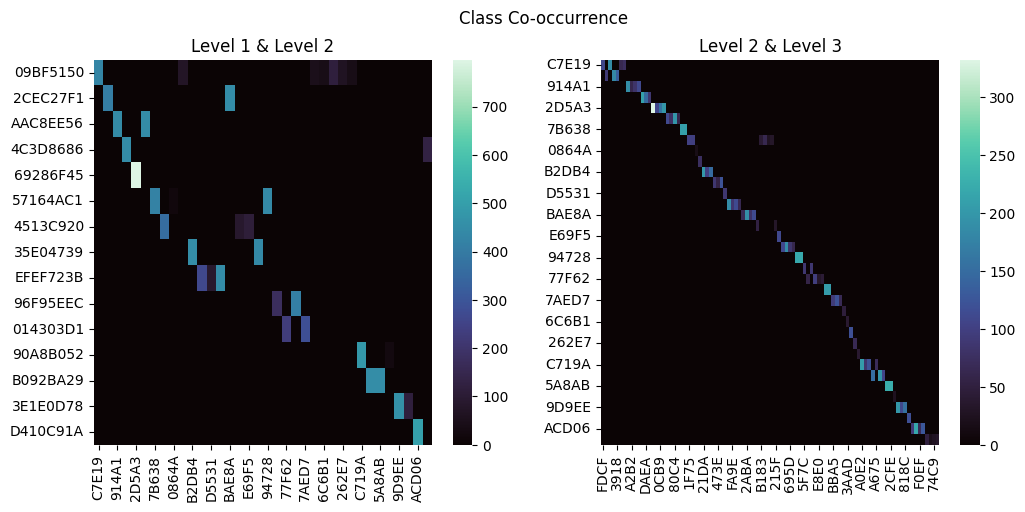

In [8]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(12,5))
fig.suptitle("Class Co-occurrence")
axes[0].set_title("Level 1 & Level 2")
axes[1].set_title("Level 2 & Level 3")

sns.heatmap(cross_1_2, ax=axes[0], cmap="mako")
sns.heatmap(cross_2_3, ax=axes[1], cmap="mako")

### Notes:
+ Looks like most classes have one or a very small number of possible sub-classes

<a id="clean"></a>

## Data Cleaning

*Missing values and duplicates are delt with then classes with <10 instances are removed.*

##### [Back to top](#top)

In [9]:
# Double check everything for Na
data.isna().value_counts()

Description  Level_1  Level_2  Level_3
False        False    False    False      10627
True         False    False    False         12
dtype: int64

In [10]:
# Drop NaN - we'll save the number of rows for reporting later
description_missing_count = len(data[data["Description"].isnull()])
data.dropna(inplace=True, how="any")

In [11]:
# Remove entirely descriptions with multiple label schemes
multiple_label_drop = data[data["Description"].isin(multiple_labels.index)].index
multiple_label_drop_count = len(data[data["Description"].isin(multiple_labels.index)].index)
data = data.drop(multiple_label_drop)

# Drop single-class duplicated descriptions
duplicates_start = len(data)
data = data.drop_duplicates()
duplicates_end = len(data)

In [12]:
# Drop Classes where the number of instances is < 10

# Apply to Level_1 
class_counts_1 = data["Level_1"].value_counts()
classes_to_remove_1 = class_counts_1[class_counts_1 < 10].index
data = data[~data["Level_1"].isin(classes_to_remove_1)]

# Apply to Level_2
class_counts_2 = data["Level_2"].value_counts()
classes_to_remove_2 = class_counts_2[class_counts_2 < 10].index
data = data[~data["Level_2"].isin(classes_to_remove_2)]

# Apply to Level_3
class_counts_3 = data["Level_3"].value_counts()
classes_to_remove_3 = class_counts_3[class_counts_3 < 10].index
data = data[~data["Level_3"].isin(classes_to_remove_3)]

<a id="process"></a>

## Text Preparation Function

*A text preparation function that implements flexible stemming and ngram tokenization.*

##### [Back to top](#top)

In [13]:
def process_text(text: str, n: int = 3, stem: bool = True, remove_numbers: bool = False) -> List[str]:
    """Func to prepare text for Count Vectorization. Converts to lowercase, 
    removes punctuation marks, removes numeric characters (optional), 
    performs Snowball steming (optional), tokenizes by word, then generates ngrams.

    Args:
        text (str): The text to be prepared.
        n (int, optional): ngram level. Defaults to 3.
        stem (bool, optional): Set to False to disable SnowballStemmer. Defaults to True.
        remove_numbers (bool, optional): Set to True to enable number removal. Defaults to False.

    Returns:
        List[str]: A list of ngram = n tokens. 
    """
    clean_tokens = []
    w_tokens = []
    lower = text.lower()
    no_punc = lower.translate(str.maketrans("", "", string.punctuation))
    tokens = no_punc.split(" ")
    if remove_numbers:
        number_re = r"[0-9]"
        for token in tokens:
            token = re.sub(number_re, "", token)
            if token != "":
                clean_tokens.append(token)
    else:
        clean_tokens = tokens
    if stem:
        stemmer = SnowballStemmer("english")
        for token in clean_tokens:
            token = stemmer.stem(token)
            if token != "":
                w_tokens.append(token)
    else:
        for token in clean_tokens:
            if token != "":
                w_tokens.append(token)
    # Unless we've asked for ngrams of one, iterate over our word tokens and populate with ngrams of n length
    if n > 1:
        tokenized_ngrams = []
        for i in range(len(w_tokens)):
            ngram = w_tokens[i:i+n]
            if len(ngram) == n:
                tokenized_ngrams.append(" ".join(ngram))
    else:
        tokenized_ngrams = w_tokens

    return tokenized_ngrams

<a id="feature"></a>

## Feature Extraction with TF-IDF

*Descripitions are vectorized using our processing function to preprocess, then pass to IDF transformer. As we spot-check the resulting matricies, we'll remove them from memory to keep things running smoothly and because sparse format is more performant in training steps.*

##### [Back to top](#top)

In [14]:
# Override the default analyzer and rely on process_text for lowercase and tokenization

# Settings to assign to process_text
ngrams = 2
stemm = False
remove_numbers = True

# Applying settings to a callable process-text func
callable_processor = process_text
callable_processor.__defaults__ = (ngrams, stemm, remove_numbers)

Cvectorizer = CV(analyzer=callable_processor)
docs = [text for text in data["Description"]]
BoW = Cvectorizer.fit_transform(docs)

In [15]:
# Let's check that the BoW looks ok
text = pd.DataFrame(BoW.toarray(), columns=Cvectorizer.get_feature_names_out())

In [16]:
# This sort will take some time, but if we want re-running will check different parts of the dataframe
col = random.randint(0, len(text.columns))
text.sort_values(by=text.columns[col],ascending=False).iloc[:10, col:col+10]

,cottonmeas tak,cottonnecklin roundsleev,cottonoff licens,cottonscreen print,cottonsoft cotton,cottonstraightregul fitzip,cottontagless protect,cottonth pant,cottonupc sku,cottony soft
5230,1,0,0,0,0,0,0,0,0,0
3730,1,0,0,0,0,0,0,0,0,0
5670,1,0,0,0,0,0,0,0,0,0
5767,1,0,0,0,0,0,0,0,0,0
3899,1,0,0,0,0,0,0,0,0,0
5079,1,0,0,0,0,0,0,0,0,0
5663,1,0,0,0,0,0,0,0,0,0
3994,1,0,0,0,0,0,0,0,0,0
5728,1,0,0,0,0,0,0,0,0,0
4193,1,0,0,0,0,0,0,0,0,0


In [17]:
# If this looks ok, let's remove it from memory
if "text" in globals():
    del text

In [18]:
# Apply term frequency inverse document frequency to the BoW
vectorizer = TfidfTransformer(use_idf=True)
text_tfidf = vectorizer.fit_transform(BoW)

In [19]:
# Let's check that the tf-idf matrix looks ok
text_tfidf_pd = pd.DataFrame(text_tfidf.toarray(), columns=Cvectorizer.get_feature_names_out())

In [20]:
col = random.randint(100, 10000)
text_tfidf_pd.sort_values(by=text_tfidf_pd.columns[col],ascending=False).iloc[:10, col:col+10]

,becom hil,becom holy,becom household,becom icon,becom indispens,becom inform,becom inst,becom intern,becom littl,becom modest
7604,0.143571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6718,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6719,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6720,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6721,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6722,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6723,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6724,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6725,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6726,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# If this looks ok, let's remove it from memory since our libraries work faster with sparse
if "text_tf_idf_pd" in globals():
    del text_tfidf_pd

<a id="train"></a>

## Train Test Split and Training

*A train test split is performed, then models are created and saved.*

##### [Back to top](#top)

In [22]:
# Create test and train sets with specified test set size
test_size = 0.28
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, data, test_size=test_size)

In [23]:
# Convenience Series for training labels
class1 = y_train["Level_1"].astype(str)
class2 = y_train["Level_2"].astype(str)
class3 = y_train["Level_3"].astype(str)

##### Model training for the three levels

In [24]:
# Create a directory for storing models if needed
try:
    os.mkdir("Models")
except FileExistsError:
    print("Models directory exists.")

Models directory exists.


In [25]:
# Create and save model for level 1
nb_1 = ComplementNB()
level_1 = nb_1.fit(X_train, class1)

pickle.dump(level_1, open("Models/level_1.pk", 'wb'))

In [26]:
# Create and save models for level 2
for class_1 in data["Level_1"].unique():
    training_labels = class2[class1 == class_1]
    level_2 = nb_1.fit(X_train[class1 == class_1], training_labels)
    pickle.dump(level_2, open(f"Models/{class_1}_level_2.pk", "wb"))

In [27]:
# Create and save models for level 3
for class_1 in data["Level_1"].unique():
    for class_2 in data[data["Level_1"] == class_1]["Level_2"].unique():
        training_labels = class3[(class1 == class_1) & (class2 == class_2)]
        level_3 = nb_1.fit(X_train[(class1 == class_1) & (class2 == class_2)], training_labels)
        pickle.dump(level_3, open(f"Models/{class_1}_{class_2}_level_3.pk", "wb"))

<a id="predict"></a>

## Prediction

*Models are applied to the test set.*

##### [Back to top](#top)

In [28]:
# Convert from sparse to facilitate iteration
X_test = X_test.todense()

In [29]:
# Keep this out of the loop since we only need it once
with open("Models/level_1.pk", "rb") as nb:
    model = pickle.load(nb)

lvl_1 = []
lvl_2 = []
lvl_3 = []

# Iterate over X_test, apply level 1 model, then check for appropriate model or file for each level
for index in range(X_test.shape[0]):
    pred_data = X_test[index, :]
    
    # Level 1
    l1 = model.predict(np.asarray(pred_data))
    lvl_1.append(l1[0])
    
    # Level 2
    l2_path = "Models/" + str(l1[0]) + "_level_2.pk"
    with open(l2_path, "rb") as nb_two:
        model_2 = pickle.load(nb_two)
    l2 = model_2.predict(np.asarray(pred_data))
    lvl_2.append(l2[0])
    
    # Level 3
    l3_path = "Models/" + str(l1[0]) + "_" + str(l2[0]) + "_level_3.pk"
    with open(l3_path, "rb") as nb_three:
        model_3 = pickle.load(nb_three)
    l3 = model_3.predict(np.asarray(pred_data))
    lvl_3.append(l3[0])

<a id="accuracy"></a>

## Accuracy by Level
##### [Back to top](#top)

In [30]:
# Level 1 accuracy
accuracy_1 = accuracy_score(y_test["Level_1"], lvl_1)

In [31]:
# Level 2 accuracy
accuracy_2 = accuracy_score(y_test["Level_2"], lvl_2)

In [32]:
# Level 3 accuracy
accuracy_3 = accuracy_score(y_test["Level_3"], lvl_3)

<a id="report"></a>

## Summary Report

#### [Back to top](#top)

In [33]:
# Print a summary report
print(f"""
Results Summary:\n\n
Records removed for missing Description - {description_missing_count}\n
Records removed for duplicate descriptions with multiple labels - {multiple_label_drop_count}\n
Records dropped for duplicated descriptions - {duplicates_start - duplicates_end}\n
Level 1 classes removed for < 10 instances - {len(classes_to_remove_1)}\n
Level 2 classes removed for < 10 instances - {len(classes_to_remove_2)}\n
Level 3 classes removed for < 10 instances - {len(classes_to_remove_3)}\n
Bag-of-words created with ngrams={callable_processor.__defaults__[0]}, Snowball stemming? {stemm}. Remove numeric? {remove_numbers}\n
Train and test sets of tf-idf transformed Bag-of-words created with a test size of {test_size}\n
Total number of models created - {len([file for file in os.listdir("Models/") if file.endswith(".pk")])}\n
Level 1 accuracy was {accuracy_1}\n
Level 2 accuracy was {accuracy_2}\n
Level 3 accuracy was {accuracy_3}
""")


Results Summary:


Records removed for missing Description - 12

Records removed for duplicate descriptions with multiple labels - 81

Records dropped for duplicated descriptions - 461

Level 1 classes removed for < 10 instances - 0

Level 2 classes removed for < 10 instances - 0

Level 3 classes removed for < 10 instances - 0

Bag-of-words created with ngrams=2, Snowball stemming? False. Remove numeric? True

Train and test sets of tf-idf transformed Bag-of-words created with a test size of 0.28

Total number of models created - 52

Level 1 accuracy was 0.8406515580736544

Level 2 accuracy was 0.7609773371104815

Level 3 accuracy was 0.28576487252124644

